In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder 
from mlxtend.frequent_patterns import association_rules
import networkx as nx 
from sklearn.cluster import KMeans

In [2]:
df =pd.read_csv("Downloads/Online Retail.csv")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,3.39,17850.0,United Kingdom


In [76]:

pd.options.mode.chained_assignment = None  # default='warn'

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Data dictionary
• InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product

• Description: Product (item) name. Nominal.

• Quantity: The quantities of each product (item) per transaction. Numeric.

• InvoiceDate: Invoice Date and time. Numeric, the day and time when each transaction was generated

• UnitPrice: Unit price. Numeric, Product price per unit in sterling.

• CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer

• Country: Country name. Nominal, the name of the country where each customer resides

In [7]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### Data Cleaning and EDA

In [8]:
#Items with negative or 0 Quantity and UnitPrice or vice versa.
df[(df.Quantity<=0) & (df.UnitPrice<=0)].shape[0]

1336

In [9]:

print("The number of records with Quantity Negative and Prices 0 or Vice versa : ",df[(df.Quantity<=0) & (df.UnitPrice<=0)].shape[0])

#Checking if Negative quantities are cancelled items 
print("Cancelled Items have Invoice Starting with : ",df.loc[(df.Quantity<0) & ~(df.CustomerID.isnull()), 'InvoiceNo'].apply(lambda x: x[0]).unique())

#Checking for Records with Negative Unit Price
print("The number of transactions with Negative Unit Price : ",df[(df.UnitPrice<0)].shape[0])

#Checking for Records with Unit Price 0
print("The number of transactions with Unit Price 0 : ",df[(df.UnitPrice==0)  & ~(df.CustomerID.isnull())].shape[0])

The number of records with Quantity Negative and Prices 0 or Vice versa :  1336
Cancelled Items have Invoice Starting with :  ['C']
The number of transactions with Negative Unit Price :  2
The number of transactions with Unit Price 0 :  40


In [10]:
#Dropping Null CustomerID transactions

df= df[df.CustomerID.notnull()]

#Dropping Transactions with UnitPrice less than 0
df = df[df.UnitPrice>0]

df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [11]:
#Saving the dataframe for further analysis

rfm_data = df.copy()

In [12]:
rfm_data["InvoiceDate"] = pd.to_datetime(rfm_data["InvoiceDate"])

In [13]:
rfm_data['TotalSales'] = rfm_data.Quantity * rfm_data.UnitPrice

In [14]:
## Extracting incomplete transactions from the dataset

df_clean = rfm_data[~rfm_data.InvoiceNo.str.contains('C',na=False)]

In [15]:
#Creating new column of Total sales
df_clean['TotalSales'] = rfm_data.Quantity * rfm_data.UnitPrice

In [16]:

# To Find The Time Period of Transactions

print(f'Oldest date is:{df_clean.InvoiceDate.min()}\n')
print(f'Latest date is:{df_clean.InvoiceDate.max()}\n')

Oldest date is:2010-01-12 08:26:00

Latest date is:2011-12-10 17:19:00



#### Order Density in Different Countries

In [17]:
df_clean.Country.value_counts(normalize=True).head(12).mul(100).round(1).astype(str)+'%'
     

United Kingdom    89.1%
Germany            2.3%
France             2.1%
EIRE               1.8%
Spain              0.6%
Netherlands        0.6%
Belgium            0.5%
Switzerland        0.5%
Portugal           0.4%
Australia          0.3%
Norway             0.3%
Italy              0.2%
Name: Country, dtype: object

<AxesSubplot:>

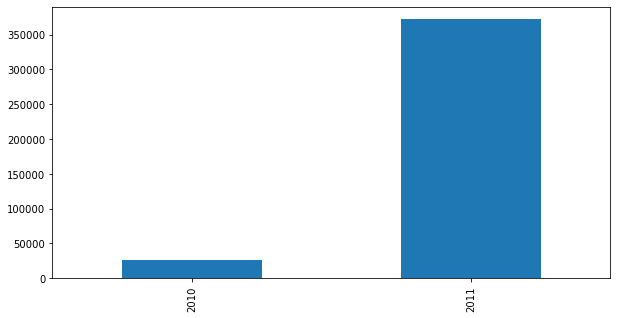

In [18]:
#Counts of orders per year
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'], errors='coerce')
df_clean.InvoiceDate.dt.year.value_counts(sort=False).plot(kind='bar', figsize=(10,5))


<AxesSubplot:>

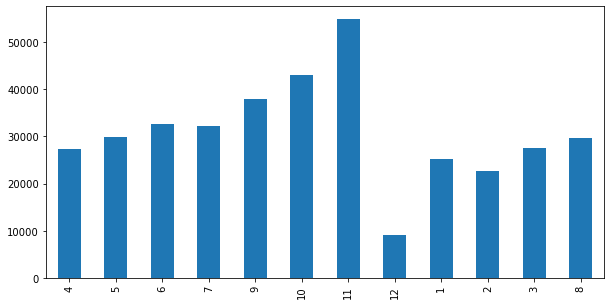

In [19]:
#Monthly Distribution of orders in 2011 since we have most transactions in 2011


df_clean[df_clean.InvoiceDate.dt.year==2011].InvoiceDate.dt.month.value_counts(sort=False).plot(kind='bar', 
                                                                                                figsize=(10,5))

#### Monthly Gross

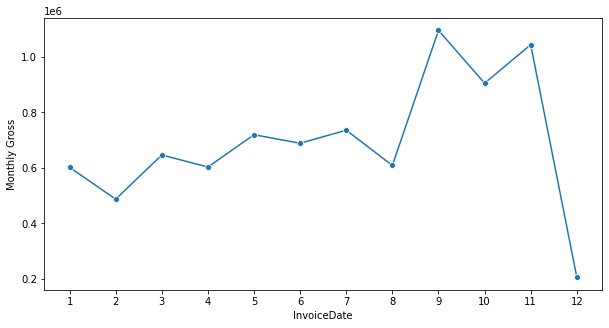

In [20]:
monthly_gross = df_clean[df_clean.InvoiceDate.dt.year==2011].groupby(df_clean.InvoiceDate.dt.month).TotalSales.sum()
plt.figure(figsize=(10,5))
sns.lineplot(y=monthly_gross.values,x=monthly_gross.index,marker='o')
plt.xticks(range(1,13))
plt.ylabel('Monthly Gross')
plt.show()

#### Unit Price distribution

<AxesSubplot:xlabel='UnitPrice'>

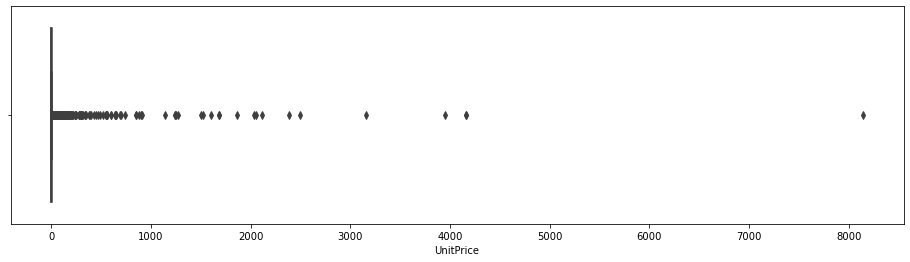

In [21]:
plt.figure(figsize=(16,4))
sns.boxplot(x='UnitPrice',data = df_clean,orient='h')


Unit Price is more concentrated in lower values of prices.

In [22]:
# Dates

# Adding features as year, month, month_year, day of week, hour:

df_clean['month'] = df_clean['InvoiceDate'].dt.month
df_clean['year'] = df_clean['InvoiceDate'].dt.year
df_clean['WeekDay'] = df_clean['InvoiceDate'].dt.day_name()
df_clean['month_year'] = pd.to_datetime(df_clean[['year', 'month']].assign(Day=1))
df_clean['hour'] = df_clean['InvoiceDate'].dt.hour
df_clean.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,month,year,WeekDay,month_year,hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,15.30,1,2010,Tuesday,2010-01-01,8
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,1,2010,Tuesday,2010-01-01,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,22.00,1,2010,Tuesday,2010-01-01,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,1,2010,Tuesday,2010-01-01,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,1,2010,Tuesday,2010-01-01,8


In [23]:
# Dataframes for plots:

plot = pd.DataFrame(df_clean.groupby(['month_year'])['InvoiceNo'].count()).reset_index()
plot2 = pd.DataFrame(df_clean.groupby(['WeekDay'])['InvoiceNo'].count()).reset_index()
plot3 = pd.DataFrame(df_clean.groupby(['hour'])['InvoiceNo'].count()).reset_index()
plot4 = pd.DataFrame(df_clean.groupby(['month_year'])['TotalSales'].mean()).reset_index()
plot5 = pd.DataFrame(df_clean.groupby(['month_year'])['TotalSales'].sum()).reset_index()

##### How many orders per day?


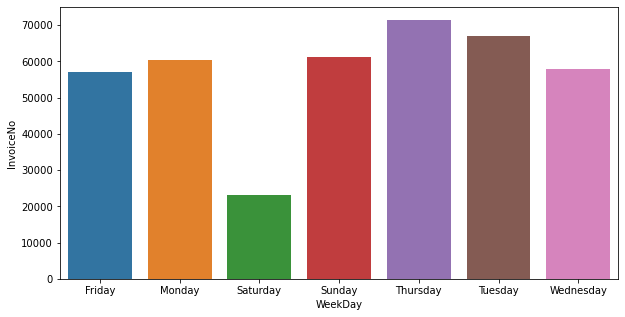

In [25]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x="WeekDay", y="InvoiceNo", data = plot2)

Interesting fact is that there were not many transactions on Saturdays during the whole period. One of the explanations colud be some filter during the data collection process. Number of buyings are not significantly differ according to the day of the week.

##### Hourly Order Distribution


 

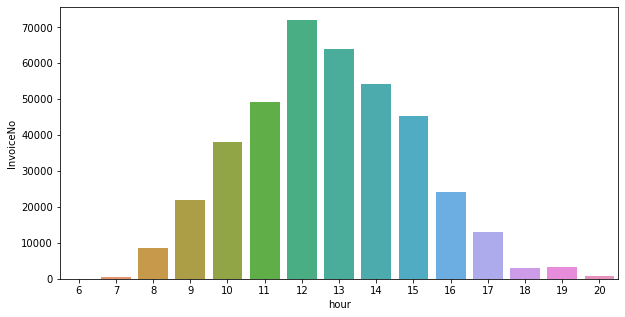

In [26]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x="hour", y="InvoiceNo", data = plot3)

The most number of transactions is done between 11 a.m. and 2 p.m., people tend to make there purchase during the lunch time. There aren't any transactions after 8 p.m. till 6 a.m.

#### Transactions by countries

In [30]:
customer_country=df_clean[['Country','CustomerID']].drop_duplicates()
customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False).head()

,Country,CustomerID
35,United Kingdom,3920
14,Germany,94
13,France,87
30,Spain,30
3,Belgium,25


In [31]:
print("Transactions were made in", len(df_clean['Country'].unique().tolist()), "different countries")

print("Number of transactions where country is unspecified:", len(df_clean[df_clean['Country']=='Unspecified']))

Transactions were made in 37 different countries
Number of transactions where country is unspecified: 244


#### Dataframe for plot:

In [32]:
plot6 = pd.DataFrame(df_clean.groupby(['Country'])['TotalSales'].sum()).reset_index()
plot6 = plot6.sort_values(['TotalSales']).reset_index(drop=True)

#### Country with most Sales

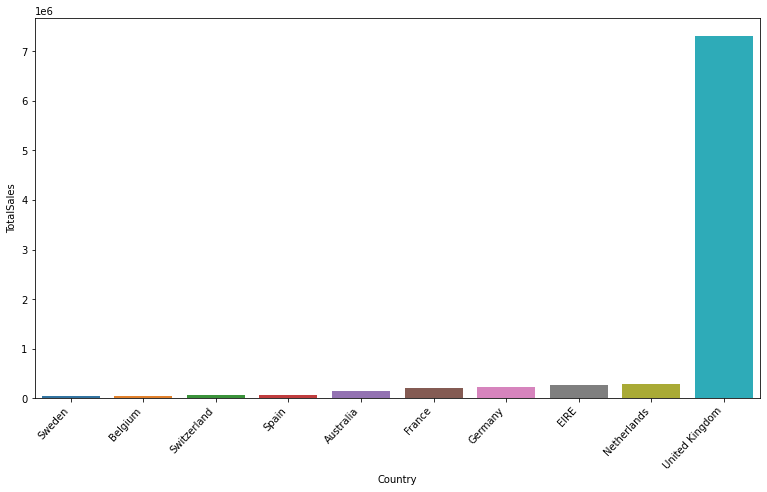

In [33]:
%matplotlib inline
fig, ax = plt.subplots()
fig.set_size_inches(13, 7)
ax=sns.barplot(x='Country', y='TotalSales',data=plot6.tail(10),estimator=max,ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=47, ha="right")
plt.show()

The biggest number of orders are made in United Kingdom, which is expected, because the store is UK-based.

In [34]:
rfm_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-09-12 12:50:00,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-09-12 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-09-12 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-09-12 12:50:00,4.15,12680.0,France,16.60


In [35]:
rfm_data['Description']=rfm_data['Description'].str.strip()
rfm_data['Country']=rfm_data['Country'].str.strip()
rfm_data['Country'] = rfm_data['Country'].astype('category')
rfm_data['InvoiceNo']=rfm_data['InvoiceNo'].astype('str')
rfm_data=rfm_data[~rfm_data['InvoiceNo'].str.contains('C')]

In [36]:
grp =rfm_data.groupby(['Country']).count()
grp.nlargest(3,'InvoiceNo')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalSales
Country,,,,,,,,
United Kingdom,354321,354321,354321,354321,354321,354321,354321,354321
Germany,9040,9040,9040,9040,9040,9040,9040,9040
France,8341,8341,8341,8341,8341,8341,8341,8341


### Association Mining
-----------
#### FRANCE
---

In [41]:
# Filtering France Store and Encoding to 0/1 bit 

fr_store=rfm_data[rfm_data['Country']=='France'
                  ].groupby(['InvoiceNo','Description'
                            ])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')

def encode_unit(x):
    if x<=0:
        return 0
    if x>=1:
        return 1
fr_store=fr_store.applymap(encode_unit)
fr_store.drop('POSTAGE',inplace=True,axis=1)  
fr_store.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,...,WRAP SUKI AND FRIENDS,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536370,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536852,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536974,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537065,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537463,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
#Applying Apriori algorithm and filtering out rules on the basis of high support,confidence,lift

frequent_items = apriori(fr_store.astype('bool'), min_support=0.04, use_colnames=True)

rules=association_rules(frequent_items, metric ='confidence',min_threshold=0.6)
rules


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE GREEN),0.102828,0.097686,0.074550,0.725000,7.421711,0.064505,3.281140
1,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE PINK),0.097686,0.102828,0.074550,0.763158,7.421711,0.064505,3.788061
2,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.095116,0.097686,0.079692,0.837838,8.576814,0.070400,5.564267
3,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.097686,0.095116,0.079692,0.815789,8.576814,0.070400,4.912229
4,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE RED),0.102828,0.095116,0.074550,0.725000,7.622297,0.064770,3.290488
...,...,...,...,...,...,...,...,...,...
62,"(SET/6 RED SPOTTY PAPER PLATES, SET/6 RED SPOT...",(SET/20 RED RETROSPOT PAPER NAPKINS),0.123393,0.133676,0.100257,0.812500,6.078125,0.083762,4.620394
63,"(SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED...",(SET/6 RED SPOTTY PAPER PLATES),0.102828,0.128535,0.100257,0.975000,7.585500,0.087040,34.858612
64,(SET/6 RED SPOTTY PAPER PLATES),"(SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED...",0.128535,0.102828,0.100257,0.780000,7.585500,0.087040,4.078056
65,(SET/20 RED RETROSPOT PAPER NAPKINS),"(SET/6 RED SPOTTY PAPER PLATES, SET/6 RED SPOT...",0.133676,0.123393,0.100257,0.750000,6.078125,0.083762,3.506427


In [43]:
rules = rules.sort_values(by='lift', ascending = False)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
10,(DOLLY GIRL CHILDRENS BOWL),(SPACEBOY CHILDRENS BOWL),0.046272,0.051414,0.041131,0.888889,17.288889,0.038752,8.537275
11,(SPACEBOY CHILDRENS BOWL),(DOLLY GIRL CHILDRENS BOWL),0.051414,0.046272,0.041131,0.800000,17.288889,0.038752,4.768638
19,(PACK OF 20 SKULL PAPER NAPKINS),(PACK OF 6 SKULL PAPER PLATES),0.048843,0.056555,0.043702,0.894737,15.820574,0.040939,8.962725
18,(PACK OF 6 SKULL PAPER PLATES),(PACK OF 20 SKULL PAPER NAPKINS),0.056555,0.048843,0.043702,0.772727,15.820574,0.040939,4.185090
20,(PACK OF 6 SKULL PAPER PLATES),(PACK OF 6 SKULL PAPER CUPS),0.056555,0.064267,0.051414,0.909091,14.145455,0.047779,10.293059
...,...,...,...,...,...,...,...,...,...
27,(PLASTERS IN TIN STRONGMAN),(PLASTERS IN TIN CIRCUS PARADE),0.082262,0.169666,0.059126,0.718750,4.236269,0.045169,2.952299
60,"(PLASTERS IN TIN STRONGMAN, PLASTERS IN TIN CI...",(PLASTERS IN TIN WOODLAND ANIMALS),0.059126,0.172237,0.041131,0.695652,4.038936,0.030947,2.719794
26,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN CIRCUS PARADE),0.136247,0.169666,0.089974,0.660377,3.892224,0.066858,2.444873
54,"(PLASTERS IN TIN WOODLAND ANIMALS, PLASTERS IN...",(PLASTERS IN TIN CIRCUS PARADE),0.105398,0.169666,0.069409,0.658537,3.881375,0.051526,2.431693


In [44]:
# Get top 5 rules
rules=pd.DataFrame(rules[['antecedents','consequents','lift','confidence','support']])
#filter top rules
top_rules_fr=rules.groupby(['antecedents',
                                 'consequents']).first().reset_index().sort_values(['support', 
                                                                                    'confidence', 
                                                                                    'lift'],ascending=False)
top_rules_fr

,antecedents,consequents,lift,confidence,support
62,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),6.915556,0.960000,0.123393
24,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),6.915556,0.888889,0.123393
16,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN WOODLAND ANIMALS),4.491411,0.773585,0.105398
8,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN SPACEBOY),4.491411,0.611940,0.105398
61,(SET/6 RED SPOTTY PAPER PLATES),(SET/20 RED RETROSPOT PAPER NAPKINS),5.984615,0.800000,0.102828
...,...,...,...,...,...
32,(PACK OF 6 SKULL PAPER PLATES),"(SET/6 RED SPOTTY PAPER PLATES, SET/6 RED SPOT...",5.893939,0.727273,0.041131
31,(PACK OF 6 SKULL PAPER PLATES),(SET/6 RED SPOTTY PAPER PLATES),5.658182,0.727273,0.041131
30,(PACK OF 6 SKULL PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),5.239057,0.727273,0.041131
20,"(PLASTERS IN TIN STRONGMAN, PLASTERS IN TIN CI...",(PLASTERS IN TIN WOODLAND ANIMALS),4.038936,0.695652,0.041131


#### GERMANY
---

In [49]:
# Filtering Germany Store and Encoding to 0/1 bit 

ge_store=rfm_data[rfm_data['Country']=='Germany'
                  ].groupby(['InvoiceNo','Description'
                            ])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')

def encode_unit(x):
    if x<=0:
        return 0
    if x>=1:
        return 1
ge_store=ge_store.applymap(encode_unit) 
ge_store.drop('POSTAGE',inplace=True,axis=1)
ge_store.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,...,YULETIDE IMAGES GIFT WRAP SET,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536840,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536861,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536967,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536983,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Apriori algorithm and filtering out rules on the basis of high support,confidence,lift

In [50]:
frequent_items = apriori(ge_store.astype('bool'), min_support=0.04, use_colnames=True)

rules=association_rules(frequent_items, metric ='confidence',min_threshold=0.6)
rules


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(JUMBO BAG RED RETROSPOT),(JUMBO BAG WOODLAND ANIMALS),0.078775,0.100656,0.048140,0.611111,6.071256,0.040211,2.312598
1,(PLASTERS IN TIN STRONGMAN),(PLASTERS IN TIN CIRCUS PARADE),0.070022,0.115974,0.048140,0.687500,5.928066,0.040019,2.828884
2,(RED RETROSPOT CHARLOTTE BAG),(WOODLAND CHARLOTTE BAG),0.070022,0.126915,0.059081,0.843750,6.648168,0.050194,5.587746
3,(ROUND SNACK BOXES SET OF 4 FRUITS),(ROUND SNACK BOXES SET OF4 WOODLAND),0.157549,0.245077,0.131291,0.833333,3.400298,0.092679,4.529540
4,(SPACEBOY LUNCH BOX),(ROUND SNACK BOXES SET OF4 WOODLAND),0.102845,0.245077,0.070022,0.680851,2.778116,0.044817,2.365427
5,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.056893,0.052516,0.045952,0.807692,15.379808,0.042964,4.926915
6,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.052516,0.056893,0.045952,0.875000,15.379808,0.042964,7.544858
7,"(ROUND SNACK BOXES SET OF4 WOODLAND, PLASTERS ...",(ROUND SNACK BOXES SET OF 4 FRUITS),0.056893,0.157549,0.041575,0.730769,4.638355,0.032612,3.129103
8,"(ROUND SNACK BOXES SET OF 4 FRUITS, PLASTERS I...",(ROUND SNACK BOXES SET OF4 WOODLAND),0.050328,0.245077,0.041575,0.826087,3.370730,0.029241,4.340810
9,"(PLASTERS IN TIN WOODLAND ANIMALS, ROUND SNACK...",(ROUND SNACK BOXES SET OF4 WOODLAND),0.048140,0.245077,0.041575,0.863636,3.523945,0.029777,5.536105


In [51]:
#Sorting rules in respect to their lift

rules = rules.sort_values(by='lift', ascending = False)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
5,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.056893,0.052516,0.045952,0.807692,15.379808,0.042964,4.926915
6,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.052516,0.056893,0.045952,0.875000,15.379808,0.042964,7.544858
2,(RED RETROSPOT CHARLOTTE BAG),(WOODLAND CHARLOTTE BAG),0.070022,0.126915,0.059081,0.843750,6.648168,0.050194,5.587746
0,(JUMBO BAG RED RETROSPOT),(JUMBO BAG WOODLAND ANIMALS),0.078775,0.100656,0.048140,0.611111,6.071256,0.040211,2.312598
1,(PLASTERS IN TIN STRONGMAN),(PLASTERS IN TIN CIRCUS PARADE),0.070022,0.115974,0.048140,0.687500,5.928066,0.040019,2.828884
7,"(ROUND SNACK BOXES SET OF4 WOODLAND, PLASTERS ...",(ROUND SNACK BOXES SET OF 4 FRUITS),0.056893,0.157549,0.041575,0.730769,4.638355,0.032612,3.129103
9,"(PLASTERS IN TIN WOODLAND ANIMALS, ROUND SNACK...",(ROUND SNACK BOXES SET OF4 WOODLAND),0.048140,0.245077,0.041575,0.863636,3.523945,0.029777,5.536105
3,(ROUND SNACK BOXES SET OF 4 FRUITS),(ROUND SNACK BOXES SET OF4 WOODLAND),0.157549,0.245077,0.131291,0.833333,3.400298,0.092679,4.529540
8,"(ROUND SNACK BOXES SET OF 4 FRUITS, PLASTERS I...",(ROUND SNACK BOXES SET OF4 WOODLAND),0.050328,0.245077,0.041575,0.826087,3.370730,0.029241,4.340810
4,(SPACEBOY LUNCH BOX),(ROUND SNACK BOXES SET OF4 WOODLAND),0.102845,0.245077,0.070022,0.680851,2.778116,0.044817,2.365427


In [78]:
#Top 5 rules
rules=pd.DataFrame(rules[['antecedents','consequents','lift','confidence','support']])
#filter top rules
top_rules_ge=rules.groupby(['antecedents',
                                 'consequents']).first().reset_index().sort_values(['support', 
                                                                                    'confidence', 
                                                                                    'lift'],ascending=False)
top_rules_ge.head()

,antecedents,consequents,lift,confidence,support
9,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),7.260672,0.626866,0.029463
14,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),18.530185,0.782923,0.029193
12,(ROSES REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),18.530185,0.690932,0.029193
6,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),14.194548,0.671736,0.028599
7,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),14.194548,0.604333,0.028599


#### United Kingdom
---

In [53]:
# Filtering France Store and Encoding to 0/1 bit 

uk_store=rfm_data[rfm_data['Country']=='United Kingdom'
                  ].groupby(['InvoiceNo','Description'
                            ])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')

def encode_unit(x):
    if x<=0:
        return 0
    if x>=1:
        return 1
uk_store=uk_store.applymap(encode_unit) 
uk_store.drop('POSTAGE',inplace=True,axis=1)
uk_store.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Applying Apriori algorithm and filtering out rules on the basis of high support,confidence,lift

In [58]:


frequent_items = apriori(uk_store.astype('bool'), min_support=0.04, use_colnames=True)

rules=association_rules(frequent_items, metric ='confidence',min_threshold=0.6)
rules


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


#### All Countries

In [63]:
# Filtering All Countries and Encoding to 0/1 bit 

all_stores=rfm_data.groupby(['InvoiceNo','Description'
                            ])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')

def encode_unit(x):
    if x<=0:
        return 0
    if x>=1:
        return 1
all_stores=all_stores.applymap(encode_unit) 
all_stores.drop('POSTAGE',inplace=True,axis=1)
all_stores.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Applying Apriori algorithm and filtering out rules on the basis of high support, confidence and lift

In [68]:

frequent_items = apriori(all_stores.astype('bool'), min_support=0.02, use_colnames=True)

rules=association_rules(frequent_items, metric ='confidence',min_threshold=0.6)
rules


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.047324,0.042575,0.028599,0.604333,14.194548,0.026584,2.419774
1,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.042575,0.047324,0.028599,0.671736,14.194548,0.026584,2.902169
2,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE RED),0.033078,0.047324,0.021368,0.646003,13.650778,0.019803,2.691201
3,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX),0.033240,0.037988,0.022879,0.688312,18.119023,0.021617,3.086454
4,(SPACEBOY LUNCH BOX),(DOLLY GIRL LUNCH BOX),0.037988,0.033240,0.022879,0.602273,18.119023,0.021617,2.430711
5,(GARDENERS KNEELING PAD KEEP CALM),(GARDENERS KNEELING PAD CUP OF TEA),0.040794,0.034265,0.024984,0.612434,17.873424,0.023586,2.491794
6,(GARDENERS KNEELING PAD CUP OF TEA),(GARDENERS KNEELING PAD KEEP CALM),0.034265,0.040794,0.024984,0.729134,17.873424,0.023586,3.541254
7,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.030002,0.037287,0.024822,0.827338,22.188466,0.023703,5.575714
8,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.037287,0.030002,0.024822,0.665702,22.188466,0.023703,2.901595
9,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.037287,0.042251,0.029193,0.782923,18.530185,0.027617,4.412029


In [69]:
# Sorting rules based on their 'lift'

rules = rules.sort_values(by='lift', ascending = False)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
19,(PINK REGENCY TEACUP AND SAUCER),"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",0.030002,0.029193,0.021045,0.701439,24.027846,0.020169,3.251619
18,"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",(PINK REGENCY TEACUP AND SAUCER),0.029193,0.030002,0.021045,0.720887,24.027846,0.020169,3.475290
17,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.023527,0.037287,0.021045,0.894495,23.989564,0.020167,9.124846
7,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.030002,0.037287,0.024822,0.827338,22.188466,0.023703,5.575714
8,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.037287,0.030002,0.024822,0.665702,22.188466,0.023703,2.901595
16,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",(ROSES REGENCY TEACUP AND SAUCER),0.024822,0.042251,0.021045,0.847826,20.066300,0.019996,6.293778
14,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.030002,0.042251,0.023527,0.784173,18.559754,0.022259,4.437569
9,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.037287,0.042251,0.029193,0.782923,18.530185,0.027617,4.412029
10,(ROSES REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.042251,0.037287,0.029193,0.690932,18.530185,0.027617,3.114894
3,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX),0.033240,0.037988,0.022879,0.688312,18.119023,0.021617,3.086454


In [80]:
#Top 5 rules

rules=pd.DataFrame(rules[['antecedents','consequents','lift','confidence','support']])
#filter top rules
top_rules_all=rules.groupby(['antecedents',
                                 'consequents']).first().reset_index().sort_values(['support', 
                                                                                    'confidence', 
                                                                                    'lift'],ascending=False)
top_rules_all.head()

,antecedents,consequents,lift,confidence,support
9,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),7.260672,0.626866,0.029463
14,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),18.530185,0.782923,0.029193
12,(ROSES REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),18.530185,0.690932,0.029193
6,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),14.194548,0.671736,0.028599
7,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),14.194548,0.604333,0.028599


#### Customer Segmentations

#### RFM Segmentation
---
RFM is a data modeling method used to analyze customer value. It stands for recency, frequency, and monetary, which are just three metrics that describe what your customers did.

Recency (R) of a customer: Days since the last purchase.
Frequency (F) of the bookings/turnover of a customer: Number of purchases, e.g., in 6 months.
Monetary (M) - The total turnover of a customer: Sum of sales, e.g., in 6 months.
For the analysis, we need to define a ‘analysis date’, which is the day on which we are conducting this analysis which I am taking as the next to last date in data and taking 1 year previous data from the selected date for recency calculation

In [71]:
analysis_date = rfm_data["InvoiceDate"].max() + pd.DateOffset(1)
print("RFM Analysis Date :", analysis_date)

start_date = analysis_date - pd.DateOffset(days = 365)
print("Start Date when taking 1 year data for analysis :", start_date)

RFM Analysis Date : 2011-12-11 17:19:00
Start Date when taking 1 year data for analysis : 2010-12-11 17:19:00


In [72]:
# Aggregate data on a customer level to get RFM values

rfm_df = rfm_data[rfm_data.InvoiceDate >= start_date].groupby(['CustomerID'],as_index=False).agg({'InvoiceDate': lambda x: (analysis_date - x.max()).days,
'InvoiceNo': 'count','TotalSales': 'sum'}).rename(columns = {'InvoiceDate': 'Recency', \
                                            'InvoiceNo': 'Frequency','TotalSales': 'Monetary'})
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,327,1,77183.60
1,12347.0,41,151,3598.21
2,12348.0,77,31,1797.24
3,12349.0,20,73,1757.55
4,12350.0,312,17,334.40


#### Getting individual RFM scores by using quantiles for each of the columns

In [73]:

rfm_df['R_score'] = pd.qcut(rfm_df['Recency'], 4, labels=False)
rfm_df['F_score'] = pd.qcut(rfm_df['Frequency'], 4, labels=False)
rfm_df['M_score'] = pd.qcut(rfm_df['Monetary'], 4, labels=False)

### Given that low Recency score means recent transactions and good customer, converting quantile values 
### so that low values rank highest ans vice versa

rfm_df['R_score'] = 3 - rfm_df['R_score']

rfm_df['RFM'] = rfm_df.R_score.map(str) \
                            + rfm_df.F_score.map(str) \
                            + rfm_df.M_score.map(str)

### Calculating Final RFM score
rfm_df["RFM_Score"] = rfm_df['R_score'] + rfm_df['F_score'] + rfm_df['M_score']
rfm_df.head(10)

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM,RFM_Score
0,12346.0,327,1,77183.60,0,0,3,003,3
1,12347.0,41,151,3598.21,2,3,3,233,8
2,12348.0,77,31,1797.24,1,1,3,113,5
3,12349.0,20,73,1757.55,3,2,3,323,8
4,12350.0,312,17,334.40,0,0,1,001,1
5,12352.0,74,85,2506.04,1,2,3,123,6
6,12353.0,205,4,89.00,0,0,0,000,0
7,12354.0,234,58,1079.40,0,2,2,022,4
8,12355.0,97,13,459.40,1,0,1,101,2
9,12356.0,24,59,2811.43,2,2,3,223,7


Going by the RFM values, it is shown that the score values range from 0 to 9 i.e, 0+0+0 to 3+3+3. However, RFM scores will be grouped to determine the mean values of RFM in respect to each score.

In [74]:
#RFM mean values

rfm_df.groupby("RFM_Score")[['Recency','Frequency', 'Monetary']].mean()

,Recency,Frequency,Monetary
RFM_Score,,,
0,248.733894,8.002801,154.049636
1,179.176152,14.102981,228.396098
2,159.637931,21.302682,361.702856
3,103.966102,27.364407,633.927439
4,97.302326,40.132558,1239.892023
5,67.008791,54.806593,1054.999607
6,55.608911,76.797030,1463.571042
7,40.390300,120.794457,1959.856605
8,26.438389,184.841232,4540.501209


In [84]:
import warnings
warnings.filterwarnings("ignore")

As expected, customers with the lowest RFM scores have the highest recency value and the lowest frequency and monetary value, and the vice-versa is true as well. This can be used to create manual segments based on RFM scores like Loyal Customers Group where Frequancy is High, High Spending Group where Monetary is High, Lost Customers Group where Recency is High etc.

Loyal and Good Customers which have High RFM values could be rewarded and heavy discounts are not needed for them. Customers with High Recency (and High Frequency and Monetary values) could be targeted aggresively with discounts so that they are not lost

#### Modeling : K - Means Clustering
To properly find out segments on our RFM values, we can use a clustering algorithm like K-means.

                ----------------- Distribution Plots for R,F,M -------------------------------


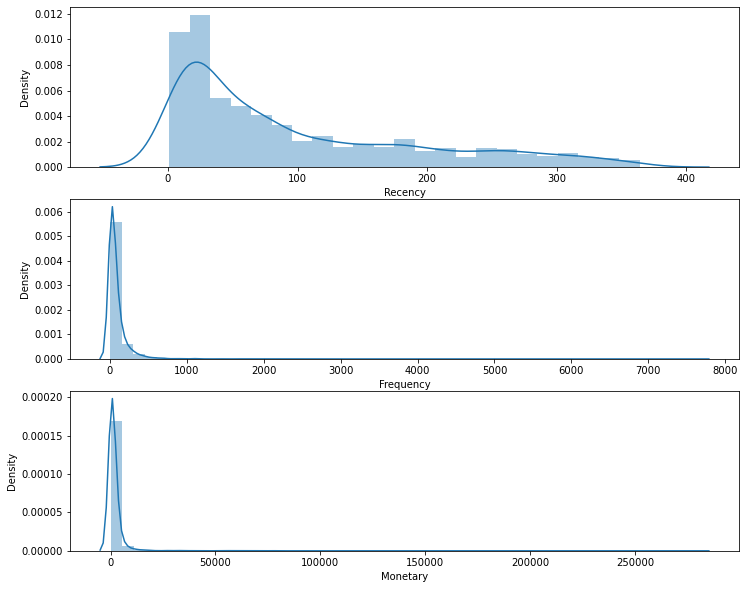

In [87]:

# Checking the distribution of Recency, Frequency and MonetaryValue variables.
plt.figure(figsize=(12,10))
# Plot distribution of var1
plt.subplot(3, 1, 1); sns.distplot(rfm_df['Recency'])
# Plot distribution of var2
plt.subplot(3, 1, 2); sns.distplot(rfm_df['Frequency'])
# Plot distribution of var3
plt.subplot(3, 1, 3); sns.distplot(rfm_df['Monetary'])


print("                ----------------- Distribution Plots for R,F,M -------------------------------")


The figure above shows that none of the variables have a symmetrical distribution. They are all tilted to the right. Data must be normalised since clustering techniques demand a normal distribution. To deal with the skewness of the data, we use the Log transformation.

                ----------------- Log Transformation Plots for R,F,M -------------------------------


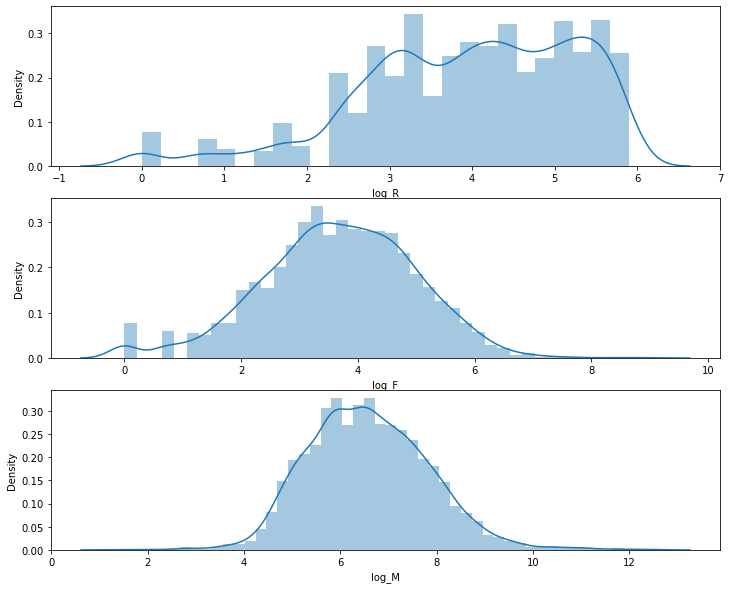

In [88]:
# Taking Log of columns
rfm_df["log_R"] = np.log(rfm_df.Recency)
rfm_df["log_F"] = np.log(rfm_df.Frequency)
rfm_df["log_M"] = np.log(rfm_df.Monetary)

# Checking the distribution of Recency, Frequency and Monetary variables after log transformation
plt.figure(figsize=(12,10))
plt.subplot(3, 1, 1)
sns.distplot(rfm_df['log_R'])
plt.subplot(3, 1, 2)
sns.distplot(rfm_df['log_F'])
plt.subplot(3, 1, 3)
sns.distplot(rfm_df['log_M'])

print("                ----------------- Log Transformation Plots for R,F,M -------------------------------")


For this work, we will utilise the Elbow approach to determine the ideal number of clusters, where errors are plotted against K (cluster value).

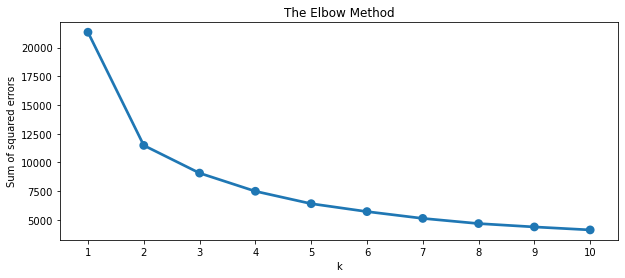

In [89]:
### Features Used in training K Means - Log Transformed Recency, Frequency and Monetary values
rfm_norm = rfm_df[["log_R", "log_F", "log_M"]]

sse = {}
# Fit KMeans and calculate SSE for each k
for k in range(1, 11):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(rfm_norm)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_
    
# Plotting the elbow plot
plt.figure(figsize=(10,4))
plt.title('The Elbow Method')
plt.xlabel('k'); 
plt.ylabel('Sum of squared errors')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

We can see from the plot above that the ideal number of clusters is 3. We will be  using 3 clusters to generate the K Means model.

In [94]:
n_clusters = 3
kmeans = KMeans(n_clusters = n_clusters, random_state=1)
kmeans.fit(rfm_norm)
rfm_df["cluster"] = kmeans.predict(rfm_norm)

In [95]:
# Checking Mean RFM values in different clusters to understand cluster properties

rfm_df.groupby(["cluster"])[['Recency','Frequency', 'Monetary']].mean()

,Recency,Frequency,Monetary
cluster,,,
0,166.089582,14.619111,292.465482
1,84.258511,66.168494,1147.731548
2,18.505894,240.961690,6027.618242


This is the RFM mean across various clusters. Frequency and Monetary have a clear relationship because of how their values fluctuate between clusters. The heat map of these three properties, which is displayed below, further demonstrates this. Recent transactions are those with a low degree of recency, while frequent transactions are those with a high frequency and high monetary value are those with a high expenditure level.

<AxesSubplot:>

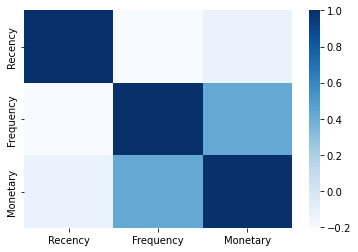

In [92]:
sns.heatmap(rfm_df[['Recency','Frequency', 'Monetary']].corr(),cmap="Blues")

Recency-Frequency and Recency-Monetary have a negative connection, whereas Frequency-Monetary has a positive association that is also evident in the change of mean values in clusters.

Text(0, 0.5, 'Monetary')

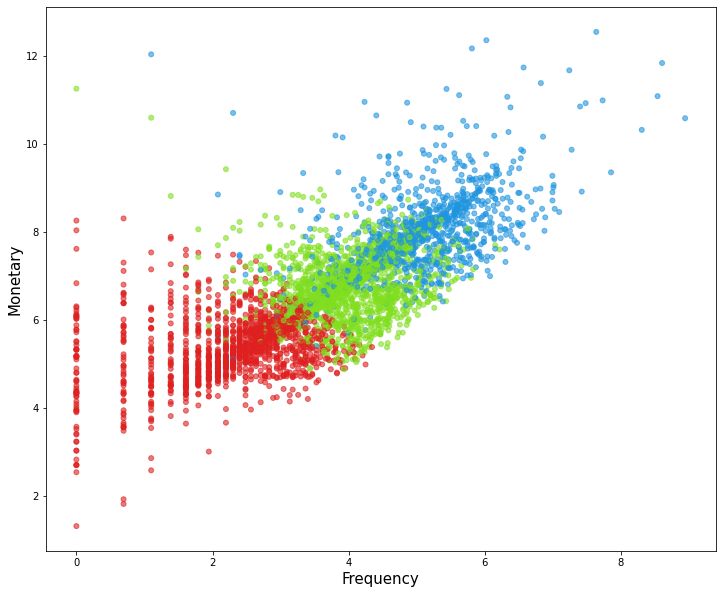

In [96]:
# get centroids
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]

## add to dataframe
rfm_df['cen_x'] = rfm_df.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
rfm_df['cen_y'] = rfm_df.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})

# define and map colors
colors = ['#DF2020', '#81DF20', '#2095DF']
rfm_df['c'] = rfm_df.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})

# Plot clusters
plt.figure(figsize=(12,10))
plt.scatter(rfm_df.log_F, rfm_df.log_M, c=rfm_df.c, alpha = 0.6, s=25)
plt.xlabel('Frequency', fontsize=15)
plt.ylabel('Monetary', fontsize=15)

#### This plot clearly indicates that blue cluster is high value customer cohort (Cluster 2) and red cluster is Lost/low value customer cohort (Cluster 0) while green cluster is average value customer cohort (Cluster 1)

High Value :- Frequent spending customers with high monetary transactions and had transacted recently

Low Value/ Lost :- Customers with least frequency and monetary spending and made purchase long time ago. These customers might be lost from the customer base.

Average Value :- Customers who made their transactions some time ago with less frequency and monetary value. These customers could become high risk and we could aggressively market towards them with great deals so we don't lose them forever.